# Bird Recognition using TensorFlow

### Referências

https://www.tensorflow.org/tutorials/audio/simple_audio#run_inference_on_an_audio_file

https://stackoverflow.com/questions/46508055/using-ffmpeg-to-cut-audio-from-to-position

https://superuser.com/questions/650291/how-to-get-video-duration-in-seconds

In [146]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Carregar arquivos de áudio

In [147]:
data_dir = pathlib.Path('../audios/wav5s')
data_dir

PosixPath('../audios/wav5s')

In [148]:
species = np.array(tf.io.gfile.listdir(str(data_dir)))
#species = species[species != 'README.md']
#species2 = [x.replace('_', ' ') for x in species.tolist()]
print('Espécies:', species.tolist())

Espécies: ['mimus_saturninus', 'columba_livia', 'caracara_plancus', 'megarynchus_pitangua', 'vanellus_chilensis', 'pitangus_sulphuratus', 'turdus_rufiventris', 'furnarius_rufus', 'theristicus_caudatus']


In [149]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir / species[0]))))
print('Example file tensor:\n ', filenames[0])

Number of total examples: 11375
Number of examples per label: 1300
Example file tensor:
  tf.Tensor(b'../audios/wav5s/vanellus_chilensis/Vanellus108380-4.wav', shape=(), dtype=string)


In [150]:
PCT_TRAINING = 0.8
PCT_VALIDATION = 0.1

train_rows = int(num_samples * PCT_TRAINING)
val_rows = int(num_samples * PCT_VALIDATION)
test_rows = num_samples - (train_rows + val_rows)

In [151]:
train_files = filenames[:train_rows]
val_files = filenames[train_rows : train_rows + val_rows]
test_files = filenames[-test_rows:]

print('Training set size..:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size......:', len(test_files))

Training set size..: 9100
Validation set size: 1137
Test set size......: 1138


In [152]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [153]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [154]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [155]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

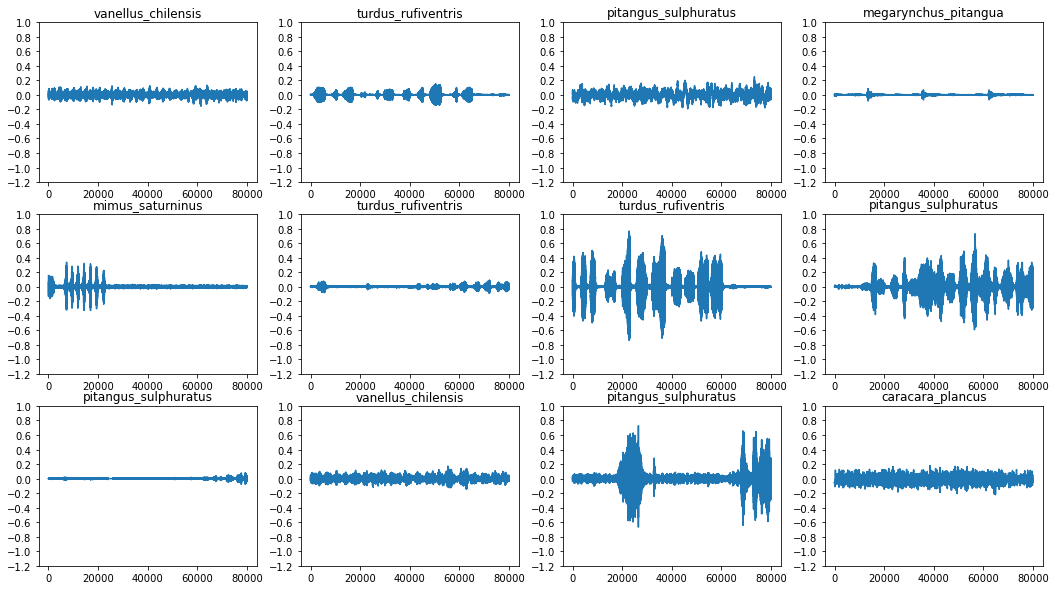

In [156]:
rows = 3
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [157]:
def get_spectrogram(waveform):
  #print("tf.shape:", tf.shape(waveform))
  #return 0

  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([80000] - tf.shape(waveform), dtype=tf.float32)
  #zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [158]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')

display.display(display.Audio(waveform, rate=16000))

Label: vanellus_chilensis
Waveform shape: (80000,)
Spectrogram shape: (624, 129)
Audio playback


<ipython-input-159-69fdc32c54bb>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


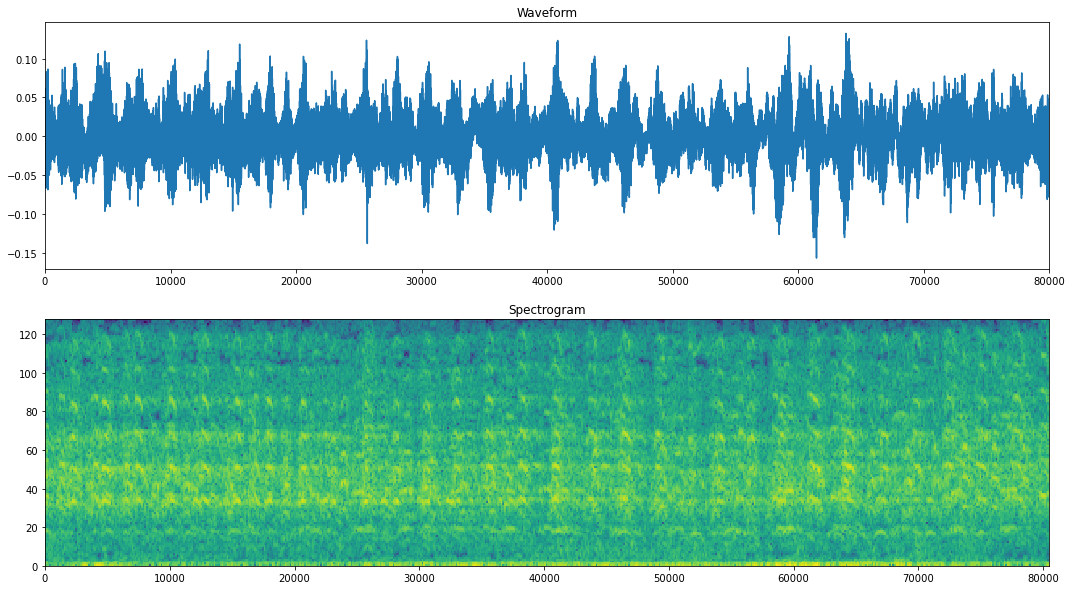

In [159]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(18, 10))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 80000])
#axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [160]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == species)
  return spectrogram, label_id

In [161]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-159-69fdc32c54bb>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)
<ipython-input-159-69fdc32c54bb>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


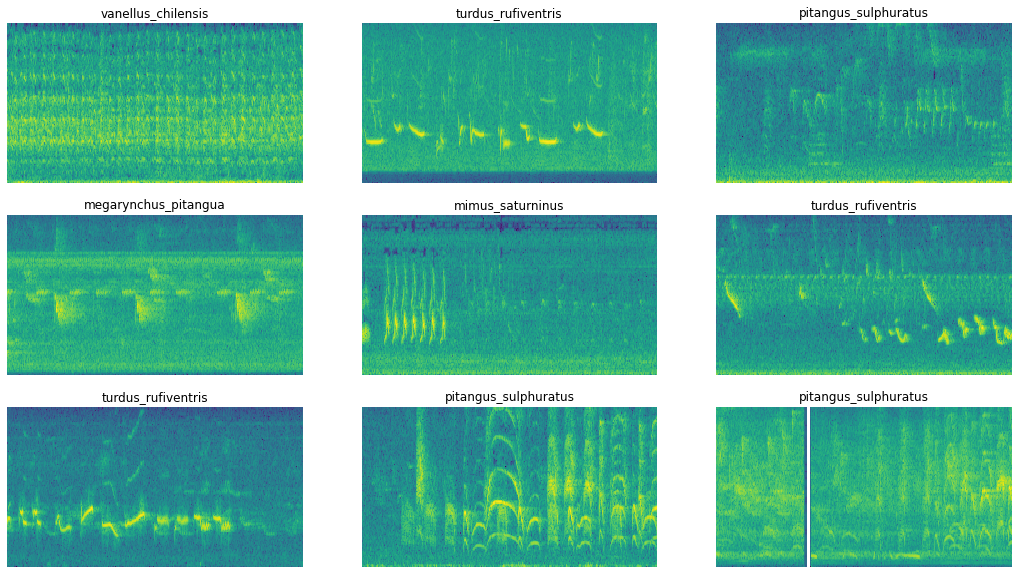

In [162]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(species[label_id.numpy()])
  ax.axis('off')

plt.show()

In [163]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
  return output_ds

In [164]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [165]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [166]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [205]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(species)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (624, 129, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)        

In [206]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [207]:
%%time

EPOCHS = 15
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
143/143 [==============================] - 6s 41ms/step - loss: 1.5648 - accuracy: 0.4784 - val_loss: 1.2899 - val_accuracy: 0.5690
Epoch 2/15
143/143 [==============================] - 6s 40ms/step - loss: 1.2308 - accuracy: 0.5824 - val_loss: 1.1251 - val_accuracy: 0.6306
Epoch 3/15
143/143 [==============================] - 6s 40ms/step - loss: 1.0656 - accuracy: 0.6359 - val_loss: 1.0124 - val_accuracy: 0.6737
Epoch 4/15
143/143 [==============================] - 6s 40ms/step - loss: 0.9305 - accuracy: 0.6830 - val_loss: 0.9342 - val_accuracy: 0.7010
Epoch 5/15
143/143 [==============================] - 6s 40ms/step - loss: 0.8573 - accuracy: 0.7068 - val_loss: 0.8832 - val_accuracy: 0.7115
Epoch 6/15
143/143 [==============================] - 6s 40ms/step - loss: 0.7762 - accuracy: 0.7284 - val_loss: 0.9139 - val_accuracy: 0.7133
Epoch 7/15
143/143 [==============================] - 6s 40ms/step - loss: 0.7207 - accuracy: 0.7520 - val_loss: 0.8920 - val_accuracy: 0.7168

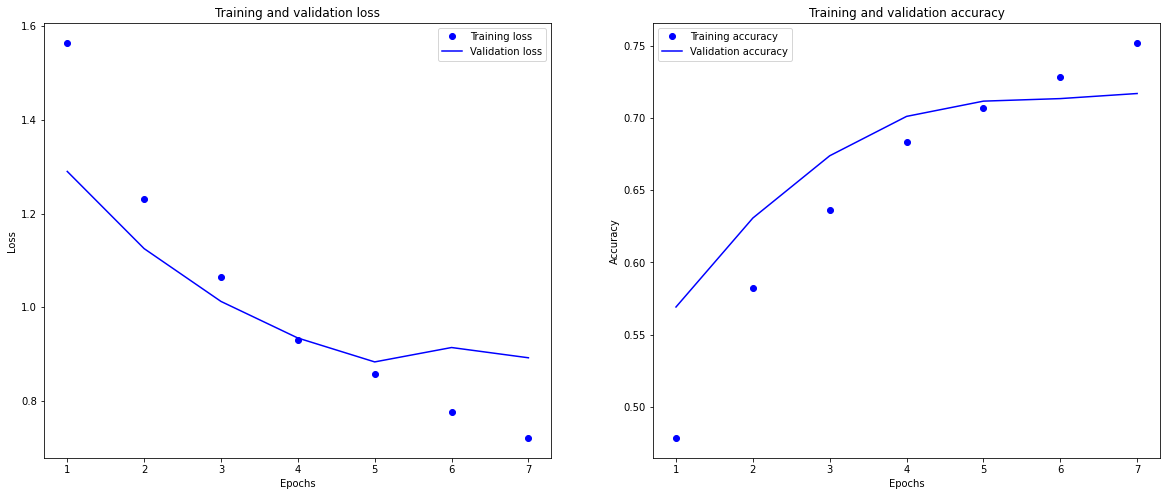

In [209]:
# Plotting the training and validation loss and accuracy
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

metrics = history.history
keys = list(metrics.keys())

loss_values = metrics[keys[0]] # loss
val_loss_values = metrics[keys[2]] # val_loss
epochs = range(1, len(metrics[keys[0]]) + 1)

ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set(title = 'Training and validation loss',
        xlabel = 'Epochs',
        ylabel = 'Loss')
ax1.legend()

acc_values = metrics[keys[1]] # accuracy
val_acc_values = metrics[keys[3]] # val_accuracy

ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set(title = 'Training and validation accuracy',
        xlabel = 'Epochs',
        ylabel = 'Accuracy')
ax2.legend()

plt.show()

## Avaliar precisão do modelo nos dados de teste

In [210]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [211]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')

Test set accuracy: 73.02%


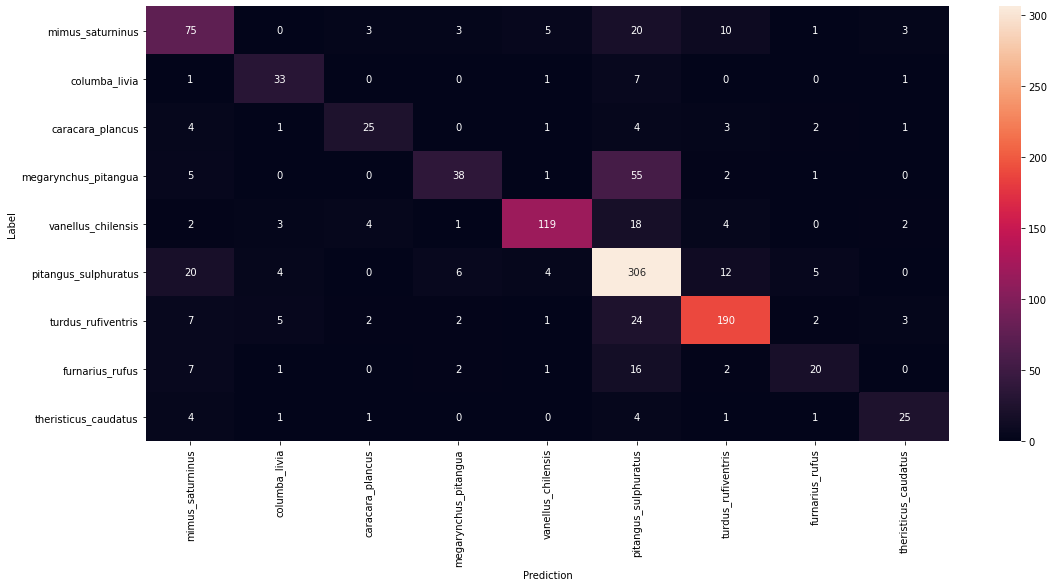

In [212]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(18, 8))
sns.heatmap(confusion_mtx,
            xticklabels=species,
            yticklabels=species, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Treinar modelo com todos os áudios

## Avaliar um único exemplar de áudio

In [213]:
#sample_file = '../audios/wav5s/caracaraplancus/Caracara587540-7.wav' #carcará
#sample_file = '../audios/wav5s/turdusrufiventris/Turdus586910-24.wav' #sabiá-laranjeira
#sample_file = '../audios/wav5seval/mimus_saturninus/Mimus645922-32.wav' #sabiá-do-campo
#sample_file = '../audios/wav5s/pitangussulphuratus/Pitangus552255-8.wav' #bem-te-vi
#sample_file = '../audios/wav5s/theristicuscaudatus/Theristicus503458-7.wav' #curicaca
#sample_file = '../audios/wav5s/columbalivia/Columba547588-10.wav' #pombo

sample_dir = '../audios/wav5seval/'
sample_file = sample_dir + 'theristicus_caudatus/357716-2.wav'
#sample_file = sample_dir + 'theristicus_caudatus/XC288519-PESC1_7_Tcaud-3.wav'

In [214]:
waveform, label = get_waveform_and_label(sample_file)
print(label)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

tf.Tensor(b'theristicus_caudatus', shape=(), dtype=string)
Audio playback


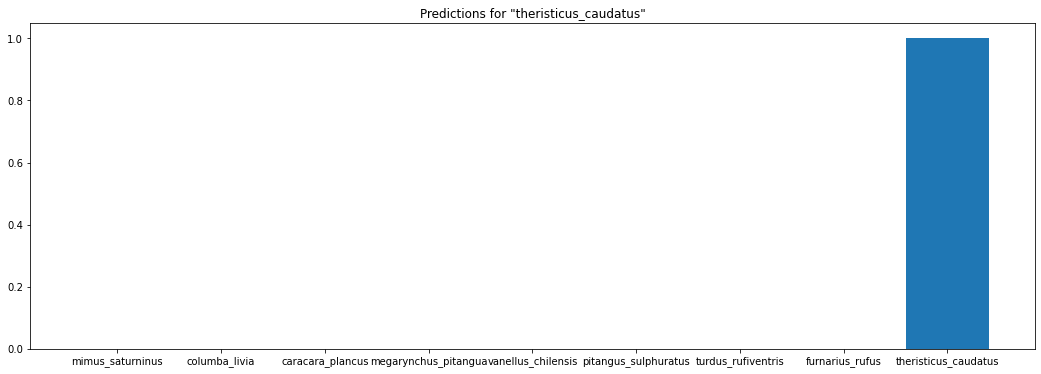

In [215]:
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.figure(figsize=(18, 6))
  plt.bar(species, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{species[label[0]]}"')
  plt.show()

## Avaliação de vários arquivos de uma única espécie

In [216]:
species.tolist()

['mimus_saturninus',
 'columba_livia',
 'caracara_plancus',
 'megarynchus_pitangua',
 'vanellus_chilensis',
 'pitangus_sulphuratus',
 'turdus_rufiventris',
 'furnarius_rufus',
 'theristicus_caudatus']

In [256]:
eval_specie = species[7]
eval_specie

'furnarius_rufus'

In [257]:
eval_dir = pathlib.Path('../audios/wav5s/' + eval_specie)
#print(eval_dir)
eval_files = tf.io.gfile.glob(str(eval_dir) + '/*.wav')
eval_ds = preprocess_dataset(eval_files)
#batch_size = 64
#eval_ds = eval_ds.batch(batch_size)
#eval_ds = eval_ds.cache().prefetch(AUTOTUNE)
eval_ds

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>

In [258]:
THRESHOLD = 0.3
value_sums = [0] * len(species)
observations = len(eval_files)

for spectrogram, label in eval_ds.batch(1):
    prediction = model(spectrogram)
    values = tf.nn.softmax(prediction[0]).numpy()
    #print(values)
    
    for i in np.arange(len(species)):
        value = values[i]
        value_sums[i] = value_sums[i] + value
        if value >= THRESHOLD:
            specie = species[i]
            #print("%20s = %3.2f" % (specie, value * 100))
    #print('\n')

In [259]:
values = np.divide(value_sums, observations).tolist()
for i in np.arange(len(species)):
    specie = species[i]
    value = values[i]
    #print("%20s = %3.2f" % (specie, value * 100))

In [260]:
import pandas as pd

df = pd.DataFrame({
    'specie': species,
    'probability': np.multiply(values, 100)
})
df.sort_values(['probability'], ascending=False).set_index(['specie'])

,probability
specie,
furnarius_rufus,51.456029
pitangus_sulphuratus,17.611763
mimus_saturninus,14.677253
megarynchus_pitangua,5.125479
vanellus_chilensis,4.376953
turdus_rufiventris,3.493231
caracara_plancus,1.536843
theristicus_caudatus,1.049453
columba_livia,0.672995
